# Learning a communication channel

Normally, if you have a function you would like to compute
across a connection, you would specify it with `function=my_func`
in the `Connection` constructor.
However, it is also possible to use error-driven learning
to learn to compute a function online.

## Step 1: Create the model without learning

We'll start by creating a connection between two populations
that initially computes a very weird function.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

In [2]:
model = nengo.Network()
with model:
    inp = nengo.Node(WhiteSignal(60, high=5), size_out=2)
    pre = nengo.Ensemble(60, dimensions=2)
    nengo.Connection(inp, pre)
    post = nengo.Ensemble(60, dimensions=2)
    conn = nengo.Connection(pre, post, function=lambda x: np.random.random(2))
    inp_p = nengo.Probe(inp)
    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)

If we run this model as is, we can see that the connection
from `pre` to `post` doesn't compute much of value.

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

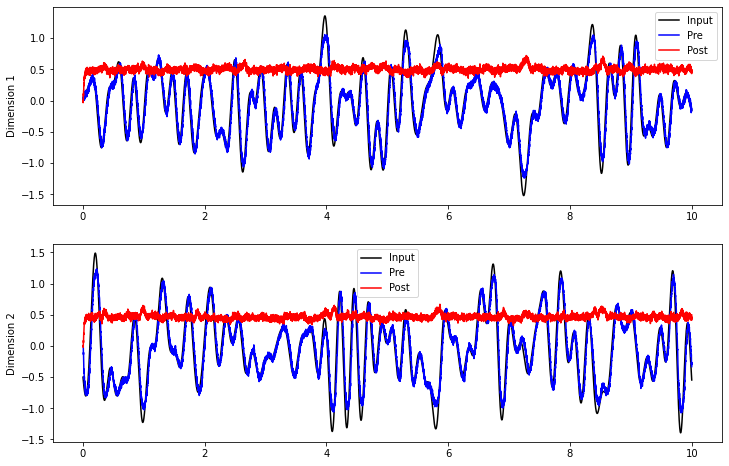

In [4]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c='k', label='Input')
plt.plot(sim.trange(), sim.data[pre_p].T[0], c='b', label='Pre')
plt.plot(sim.trange(), sim.data[post_p].T[0], c='r', label='Post')
plt.ylabel("Dimension 1")
plt.legend(loc='best')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[inp_p].T[1], c='k', label='Input')
plt.plot(sim.trange(), sim.data[pre_p].T[1], c='b', label='Pre')
plt.plot(sim.trange(), sim.data[post_p].T[1], c='r', label='Post')
plt.ylabel("Dimension 2")
plt.legend(loc='best');

## Step 2: Add in learning

If we can generate an error signal, then we can minimize
that error signal using the `nengo.PES` learning rule.
Since it's a communication channel, we know the value that we want,
so we can compute the error with another ensemble.

In [5]:
with model:
    error = nengo.Ensemble(60, dimensions=2)
    error_p = nengo.Probe(error, synapse=0.03)

    # Error = actual - target = post - pre
    nengo.Connection(post, error)
    nengo.Connection(pre, error, transform=-1)

    # Add the learning rule to the connection
    conn.learning_rule_type = nengo.PES()

    # Connect the error into the learning rule
    nengo.Connection(error, conn.learning_rule)

Now, we can see the `post` population gradually learn to compute
the communication channel.

In [6]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

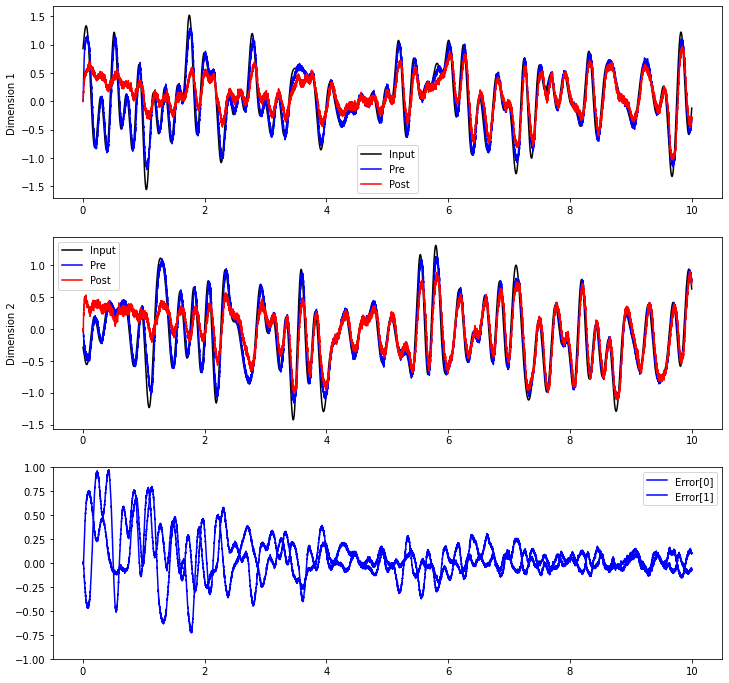

In [7]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c='k', label='Input')
plt.plot(sim.trange(), sim.data[pre_p].T[0], c='b', label='Pre')
plt.plot(sim.trange(), sim.data[post_p].T[0], c='r', label='Post')
plt.ylabel("Dimension 1")
plt.legend(loc='best')
plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[inp_p].T[1], c='k', label='Input')
plt.plot(sim.trange(), sim.data[pre_p].T[1], c='b', label='Pre')
plt.plot(sim.trange(), sim.data[post_p].T[1], c='r', label='Post')
plt.ylabel("Dimension 2")
plt.legend(loc='best')
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[error_p], c='b')
plt.ylim(-1, 1)
plt.legend(("Error[0]", "Error[1]"), loc='best');

## Does it generalize?

If the learning rule is always working,
the error will continue to be minimized.
But have we actually generalized
to be able to compute the communication channel
without this error signal?
Let's inhibit the `error` population after 10 seconds.

In [8]:
def inhibit(t):
    return 2.0 if t > 10.0 else 0.0


with model:
    inhib = nengo.Node(inhibit)
    nengo.Connection(inhib, error.neurons, transform=[[-1]] * error.n_neurons)

In [9]:
with nengo.Simulator(model) as sim:
    sim.run(16.0)

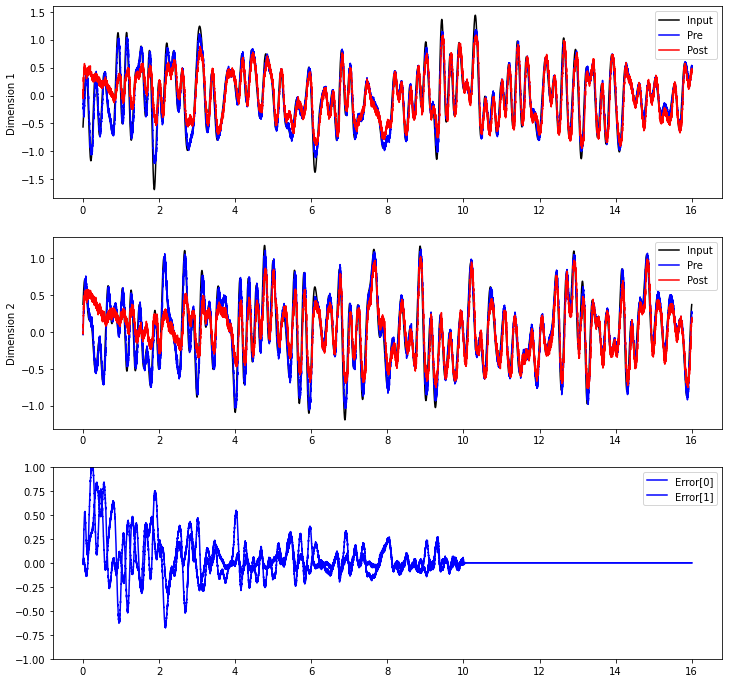

In [10]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c='k', label='Input')
plt.plot(sim.trange(), sim.data[pre_p].T[0], c='b', label='Pre')
plt.plot(sim.trange(), sim.data[post_p].T[0], c='r', label='Post')
plt.ylabel("Dimension 1")
plt.legend(loc='best')
plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[inp_p].T[1], c='k', label='Input')
plt.plot(sim.trange(), sim.data[pre_p].T[1], c='b', label='Pre')
plt.plot(sim.trange(), sim.data[post_p].T[1], c='r', label='Post')
plt.ylabel("Dimension 2")
plt.legend(loc='best')
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[error_p], c='b')
plt.ylim(-1, 1)
plt.legend(("Error[0]", "Error[1]"), loc='best');

## How does this work?

The `nengo.PES` learning rule minimizes the same error online
as the decoder solvers minimize with offline optimization.

Let $\mathbf{E}$ be an error signal.
In the communication channel case, the error signal
$\mathbf{E} = \mathbf{\hat{x}} - \mathbf{x}$;
in other words, it is the difference between
the decoded estimate of `post`, $\mathbf{\hat{x}}$,
and the decoded estimate of `pre`, $\mathbf{x}$.

The PES learning rule on decoders is

$$\Delta \mathbf{d_i} = -\frac{\kappa}{n} \mathbf{E} a_i$$

where $\mathbf{d_i}$ are the decoders being learned,
$\kappa$ is a scalar learning rate, $n$ is the number of neurons
in the `pre` population,
and $a_i$ is the filtered activity of the `pre` population.

However, many synaptic plasticity experiments
result in learning rules that explain how
individual connection weights change.
We can multiply both sides of the equation
by the encoders of the `post` population,
$\mathbf{e_j}$, and the gain of the `post`
population $\alpha_j$, as we do in
Principle 2 of the NEF.
This results in the learning rule

$$
\Delta \omega_{ij} = \Delta \mathbf{d_i} \cdot \mathbf{e_j} \alpha_j
  = -\frac{\kappa}{n} \alpha_j \mathbf{e_j} \cdot \mathbf{E} a_i
$$

where $\omega_{ij}$ is the connection
between `pre` neuron $i$ and `post` neuron $j$.

The weight-based version of PES can be easily combined with
learning rules that describe synaptic plasticity experiments.
In Nengo, the `Connection.learning_rule_type` parameter accepts
a list of learning rules.
See [Bekolay et al., 2013](
http://compneuro.uwaterloo.ca/publications/bekolay2013.html)
for details on what happens when the PES learning rule is
combined with an unsupervised learning rule.

## How do the decoders / weights change?

The equations above describe
how the decoders and connection weights change
as a result of the PES rule.
But are there any general principles
that we can say about how the rule
modifies decoders and connection weights?
Determining this requires analyzing
the decoders and connection weights
as they change over the course of a simulation.

In [11]:
with model:
    weights_p = nengo.Probe(conn, 'weights', synapse=0.01, sample_every=0.01)

In [12]:
with nengo.Simulator(model) as sim:
    sim.run(4.0)

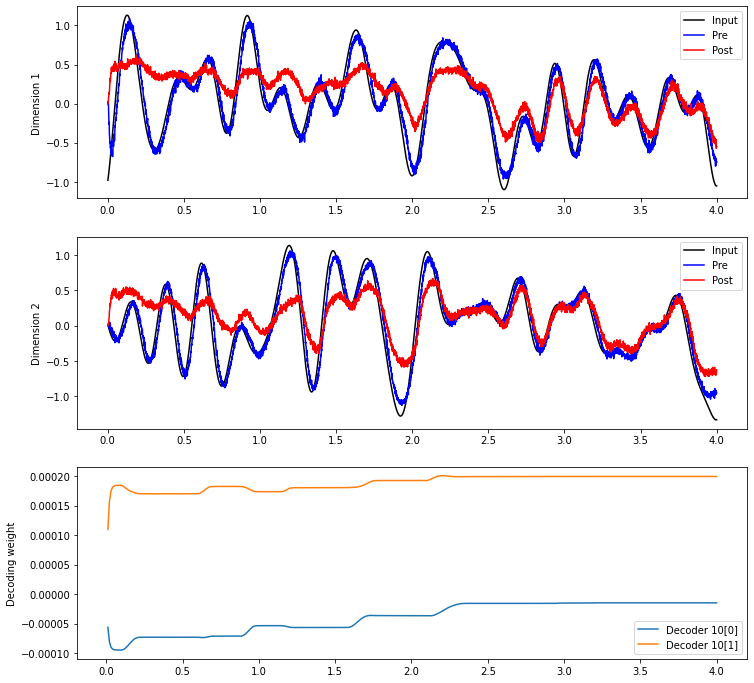

In [13]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c='k', label='Input')
plt.plot(sim.trange(), sim.data[pre_p].T[0], c='b', label='Pre')
plt.plot(sim.trange(), sim.data[post_p].T[0], c='r', label='Post')
plt.ylabel("Dimension 1")
plt.legend(loc='best')
plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[inp_p].T[1], c='k', label='Input')
plt.plot(sim.trange(), sim.data[pre_p].T[1], c='b', label='Pre')
plt.plot(sim.trange(), sim.data[post_p].T[1], c='r', label='Post')
plt.ylabel("Dimension 2")
plt.legend(loc='best')
plt.subplot(3, 1, 3)
plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p][..., 10])
plt.ylabel("Decoding weight")
plt.legend(("Decoder 10[0]", "Decoder 10[1]"), loc='best');

In [14]:
with model:
    # Change the connection to use connection weights instead of decoders
    conn.solver = LstsqL2(weights=True)

In [15]:
with nengo.Simulator(model) as sim:
    sim.run(4.0)

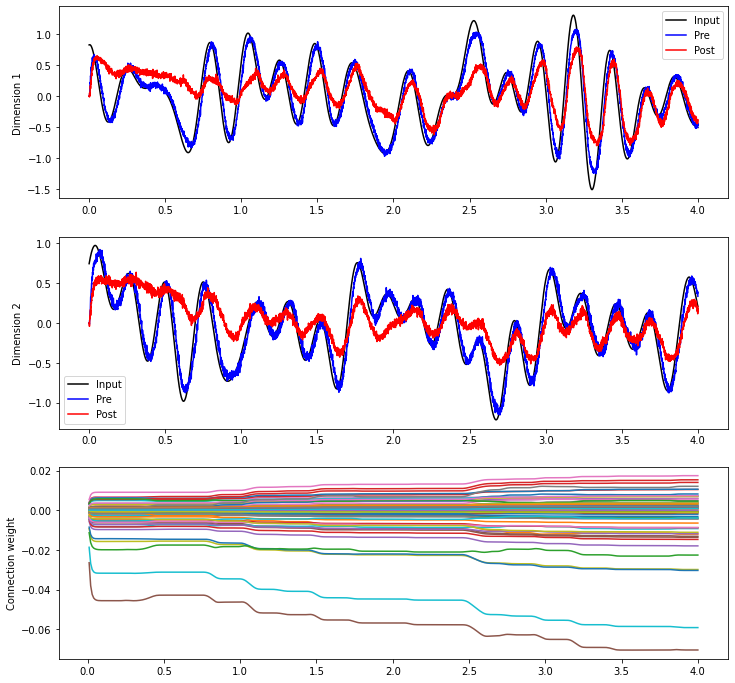

In [16]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c='k', label='Input')
plt.plot(sim.trange(), sim.data[pre_p].T[0], c='b', label='Pre')
plt.plot(sim.trange(), sim.data[post_p].T[0], c='r', label='Post')
plt.ylabel("Dimension 1")
plt.legend(loc='best')
plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[inp_p].T[1], c='k', label='Input')
plt.plot(sim.trange(), sim.data[pre_p].T[1], c='b', label='Pre')
plt.plot(sim.trange(), sim.data[post_p].T[1], c='r', label='Post')
plt.ylabel("Dimension 2")
plt.legend(loc='best')
plt.subplot(3, 1, 3)
plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p][..., 10])
plt.ylabel("Connection weight");

For some general principles governing how the decoders change,
[Voelker, 2015](http://compneuro.uwaterloo.ca/publications/voelker2015.html)
and [Voelker & Eliasmith, 2017](
http://compneuro.uwaterloo.ca/publications/voelker2017c.html)
give detailed analyses of the rule's dynamics.
It's also interesting to observe qualitative trends;
often a few strong connection weights will
dominate the others,
while decoding weights tend to
change or not change together.

## What is `pre_synapse`?

By default the `PES` object sets
`pre_synapse=Lowpass(tau=0.005)`.
This is a lowpass filter with time-constant $\tau = 5\,\text{ms}$
that is applied to the activities of the pre-synaptic population $a_i$
before computing each update $\Delta {\bf d}_i$.

In general, longer time-constants
smooth over the spiking activity to produce more constant updates,
while shorter time-constants adapt more quickly
to rapidly changing inputs.
The right trade-off depends on
the particular demands of the model.

This `Synapse` object can also be
any other linear filter (as are used in the `Connection` object);
for instance, `pre_synapse=Alpha(tau=0.005)`
applies an alpha filter to the postsynaptic activity.
This will have the effect of delaying the bulk of the activities
by a rise-time of $\tau$ before applying the update.
This may be useful for situations
where the error signal is delayed by the same amount,
since the error signal should be synchronized
with the same activities that produced said error.